Meilleurs hyperparamètres pour XGBoost :  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
---- Résultats XGBoost ----
MAE : 9520.535546875
RMSE : 23892.615736174397
R² : 0.999143831317119
---- Résultats Linear Regression ----
MAE : 151196.4103620193
RMSE : 234338.538623201
R² : 0.9176394239045035
---- Résultats Random Forest ----
MAE : 71205.10891858142
RMSE : 349722.03514097066
R² : 0.8165668030127102

--- Comparaison des MAE ---
MAE XGBoost         : 9520.54
MAE LinearRegression: 151196.41
MAE RandomForest    : 71205.11


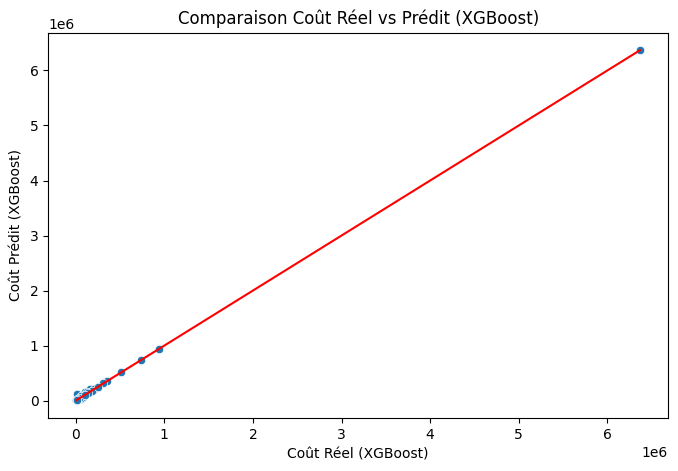


✅ Meilleur modèle XGBoost sauvegardé dans 'best_xgboost_model.pkl'


In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Connexion à la base de données PostgreSQL
USERNAME = os.getenv("POSTGRES_USER", "postgres")
PASSWORD = os.getenv("POSTGRES_PASSWORD", "123456789")
HOST = os.getenv("POSTGRES_HOST", "localhost")
PORT = os.getenv("POSTGRES_PORT", "5432")
DATABASE = os.getenv("POSTGRES_DB", "DBM")

DATABASE_URL = f"postgresql://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
engine = create_engine(DATABASE_URL)

# Requête SQL pour charger les données
query_finance = """
SELECT "PK_Patient", "PK_Dep", "Facility_Cost", "Procedure_Cost", "ICU_Stay", 
       "normal_Admission_Stay", "Total_Cost"
FROM public."FACT_FINANCE";
"""

query_departments = """
SELECT "PK_Dep", "Department_Type"
FROM public."DIM_DEPARTMENT";
"""

# Chargement des données
finance = pd.read_sql(query_finance, engine)
departments = pd.read_sql(query_departments, engine)

# Fusionner les données
data = finance.merge(departments, on="PK_Dep", how="left")

# Sélection des colonnes utiles
cols = [
    "Facility_Cost", "Procedure_Cost", "ICU_Stay", "normal_Admission_Stay",
    "Department_Type", "Total_Cost"
]
df = data[cols].dropna()

# Encodage de la colonne "Department_Type"
df["Department_Type"] = LabelEncoder().fit_transform(df["Department_Type"])

# Séparation des features et de la cible
X = df.drop("Total_Cost", axis=1)
y = df["Total_Cost"]

# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Fonction d’évaluation des modèles
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"---- Résultats {model_name} ----")
    print(f"MAE : {mae}")
    print(f"RMSE : {rmse}")
    print(f"R² : {r2}")
    return mae, rmse, r2

# --- Optimisation avec GridSearchCV pour XGBoost ---
param_grid_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Meilleurs hyperparamètres pour XGBoost
print("Meilleurs hyperparamètres pour XGBoost : ", grid_search_xgb.best_params_)

# --- XGBoost ---
xgb_model = XGBRegressor(
    n_estimators=grid_search_xgb.best_params_['n_estimators'],
    learning_rate=grid_search_xgb.best_params_['learning_rate'],
    max_depth=grid_search_xgb.best_params_['max_depth'],
    subsample=grid_search_xgb.best_params_['subsample'],
    colsample_bytree=grid_search_xgb.best_params_['colsample_bytree'],
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb, rmse_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mae_lr, rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")

# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mae_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Comparaison des erreurs
print("\n--- Comparaison des MAE ---")
print(f"MAE XGBoost         : {mae_xgb:.2f}")
print(f"MAE LinearRegression: {mae_lr:.2f}")
print(f"MAE RandomForest    : {mae_rf:.2f}")

# Visualisation des prédictions XGBoost
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.xlabel("Coût Réel (XGBoost)")
plt.ylabel("Coût Prédit (XGBoost)")
plt.title("Comparaison Coût Réel vs Prédit (XGBoost)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()

# Sauvegarde du modèle XGBoost
joblib.dump(xgb_model, "best_xgboost_model.pkl")
print("\n✅ Meilleur modèle XGBoost sauvegardé dans 'best_xgboost_model.pkl'")

